In [ ]:
def bet_positive_dutch(runners, bet_chunk):
    """dutch betting on probability"""

    # drop scratched
    runners = [r for r in runners if r['odds_win']]
    num_runners = len(runners)    
    if not num_runners:
        return [], 0

    # sort runners from favourite to underdog
    runners.sort(key=itemgetter('probability'), reverse=True)

    # start betting on all and cut off worse runner till positive outcome
    for num_bets in range(num_runners, 0, -1):

        # reset bets for all
        for runner in runners:
            runner['bet'] = 0

        # recreate smaller pool
        pool = runners[:num_bets]
        # print('pool is {} from {} bets'.format(len(pool), num_bets))

        # all odds
        total = sum([r['probability'] for r in pool])
        # print('total probability = {}'.format(total))

        # dutch for all in pool
        profits = []
        for runner in pool:
            runner['bet'] = runner['probability'] / total * bet_chunk
            profits.append(runner['bet'] * runner['odds_win'] - bet_chunk)

        # exit when profitable
        # need to check all as we scale to probs and not odds
        if all(p > 0 for p in profits):
            break
    else:
        print('no profit determined')
        return [], 0
    
    # ignore anyone's game runs
    # 100%   -1% (2541)
    # < 70%  -1% (2540)
    # < 60%  -1% (2523)
    # < 50%  -1% (2342)
    # < 45%  -2% (2283)
    # < 40%  6%  (658)
    # < 35%  5%  (507)
    # < 30%  5%  (324)
    # < 25%  15% (175)
    # < 20%  15% (131)
    # < 15%  only 78 games
    # < 10%  -
    # print('num bets per runners {:.2f}'.format(num_bets / num_runners))
#     if num_bets / num_runners >= 0.45:
        # print('num bets {} num runners {}'.format(num_bets, num_runners))
#         return [], 0
    
    return pool, num_bets


dfo = dfo.sample(frac=1).reset_index(drop=True)
print('Dataframe shuffled!')

book = process_strategy(dfo, bet_positive_dutch)

In [8]:
def bet_positive_only(runners, bet_chunk):
    """if prob > odds, bet"""
    # 2540  -4%
    # 3019  -6%
    
    # total (only of runners we are betting on)
    all_probs = [r['probability'] for r in runners if bettable(r)]
    total_probs = sum(all_probs)
    
    for runner in runners:
#         runner['bet'] = runner['odds_scale'] / total_scaled * bet_chunk if bettable(runner) else 0
        runner['bet'] = runner['probability'] / total_probs * bet_chunk if bettable(runner) else 0

    num_bets = sum(r['bet'] > 0 for r in runners)
    return runners, num_bets


dfo = dfo.sample(frac=1).reset_index(drop=True)
print('Dataframe shuffled!')

book = process_strategy(dfo, bet_positive_only)

Dataframe shuffled!


In [1]:
from sqlalchemy import create_engine
from operator import itemgetter
import json

import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
engine = create_engine('sqlite:///tab.db')
conn = engine.connect()

dfo = pd.read_sql_table('race', conn)
print('{} races loaded!'.format(len(dfo)))
dfo = dfo.loc[dfo['race_type'].isin(['R'])]
print('{} horse races!'.format(len(dfo)))

9168 races loaded!
3021 horse races!


In [3]:
dfo['results'] = dfo['results_data'].map(json.loads)
dfo['runners'] = dfo['runners_data'].map(json.loads)
dfo.describe()

,id,race_number,race_distance,num_runners
count,3021.000000,3021.000000,3021.000000,3021.00000
mean,5262.337637,4.660377,1671.842767,9.58954
std,2505.808731,2.515617,764.832350,2.89044
min,1610.000000,1.000000,402.000000,3.00000
25%,2878.000000,3.000000,1200.000000,7.00000
50%,5148.000000,5.000000,1400.000000,9.00000
75%,7383.000000,7.000000,1800.000000,12.00000
max,9718.000000,12.000000,6400.000000,22.00000


In [4]:
# bet size
balance = 1000
bet_chunk = balance * 0.05

In [5]:
def bettable(r):
    return r['probability'] > r['odds_scale'] and r['odds_win'] > 0

In [6]:
def process_strategy(df, strategy):
    """run strategy, must pass runners returned back into results (it might be modified)"""
    book = []
    for _, race in df.iterrows():
#         print(race['num_runners'])
        runners = race['runners']
        runners, num_bets = strategy(runners, bet_chunk)
        if num_bets:
            bet_results(book, runners, race['num_runners'], bet_chunk, num_bets, race['race_type'])
    return book

In [7]:
def bet_results(book, runners, num_runners, bet_chunk, num_bets, race_type):
    """get results from bets"""
    win_diff = 0
    max_diff = 0
    outcome = {
        'success': 0,
        'profit': -bet_chunk,
        'num_bets': num_bets,
        'num_runners': num_runners,
    }
    for i, runner in enumerate(runners):
        diff = abs(runner['odds_scale'] - runner['probability'])
        max_diff = max(max_diff, diff)
        if int(runner['finishingPosition']) == 1:
            win_diff = diff
            if runner['bet'] > 0:
                # odds = runner['parimutuel']['returnWin'] if runner['parimutuel']['returnWin'] else runner['odds_win']
                odds = runner['odds_win']
                profit = runner['bet'] * odds - bet_chunk
                outcome = {
                    'success': 1,
                    'profit': profit,
                    'num_bets': num_bets,
                    'num_runners': num_runners,
                }
            break

    outcome['max_diff'] = max_diff
    outcome['win_diff'] = win_diff
    outcome['bet_chunk'] = bet_chunk
    outcome['race_type'] = race_type
    outcome['runners'] = runners
    book.append(outcome)

In [48]:
def bet_positive_max(runners, bet_chunk):
    """bet max given prob>scale"""

    num_runners = sum(r['odds_win'] > 0 for r in runners)
    max_diff = max(r['probability'] - r['odds_scale'] for r in runners)

    for runner in runners:
        runner['bet'] = 0
        if runner['probability'] - runner['odds_scale'] == max_diff:
            runner['bet'] = bet_chunk
            
    num_bets = sum(r['bet'] > 0 for r in runners)
    
    if num_bets > 2 or num_bets / num_runners < 0.125:
        return [], 0
        
    return runners, num_bets


dfo = dfo.sample(frac=1).reset_index(drop=True)
print('Dataframe shuffled!')

book = process_strategy(dfo, bet_positive_max)

Dataframe shuffled!


In [49]:
df = pd.DataFrame(book)
df.tail(10)

,bet_chunk,max_diff,num_bets,num_runners,profit,race_type,runners,success,win_diff
1164,50.0,0.031045,1,5.0,-50.0,R,"[{'runnerName': 'MIDNIGHT WALK', 'runnerNumber...",0,0.031045
1165,50.0,0.145203,1,5.0,57.5,R,"[{'runnerName': 'MIZEN MASTER', 'runnerNumber'...",1,0.145203
1166,50.0,0.032614,1,8.0,145.0,R,"[{'runnerName': 'BALL LIGHTNING', 'runnerNumbe...",1,0.032614
1167,50.0,0.045955,1,5.0,50.0,R,"[{'runnerName': 'PONDERING', 'runnerNumber': 6...",1,0.045955
1168,50.0,0.038681,1,7.0,-50.0,R,"[{'runnerName': 'ADIR', 'runnerNumber': 1, 'fi...",0,0.000906
1169,50.0,0.035464,1,7.0,-50.0,R,"[{'runnerName': 'PIONEERTOWN', 'runnerNumber':...",0,0.035464
1170,50.0,0.062757,1,6.0,-50.0,R,"[{'runnerName': 'QUINTIN', 'runnerNumber': 6, ...",0,0.022457
1171,50.0,0.131567,1,4.0,-50.0,R,"[{'runnerName': 'CHARLIE RASCAL', 'runnerNumbe...",0,0.023474
1172,50.0,0.254060,1,7.0,-50.0,R,"[{'runnerName': 'UNYIELDING', 'runnerNumber': ...",0,0.012927
1173,50.0,0.076693,1,7.0,-50.0,R,"[{'runnerName': 'RUTHERFORD', 'runnerNumber': ...",0,0.031339


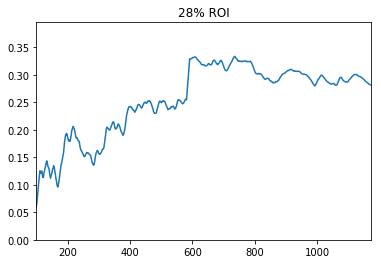

In [59]:
# ROI
roi = df.profit.cumsum() / df.bet_chunk.cumsum()
roi_title = '{:.0f}% ROI'.format(roi.iloc[-1] * 100)
roi.rolling(10).mean().plot(title=roi_title, xlim=(100), ylim=(0))

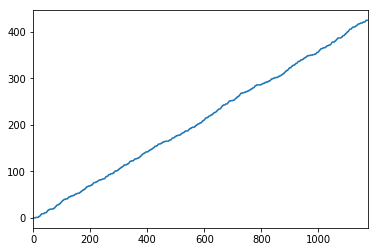

In [60]:
df.success.cumsum().plot()

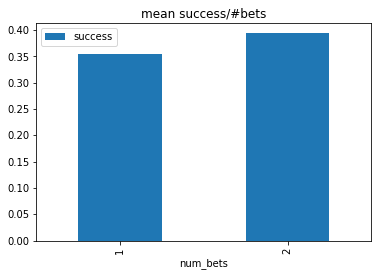

In [51]:
# profit per num bets 
groups = df.groupby('num_bets').mean()
groups.plot(kind='bar', y='success', title='mean success/#bets')

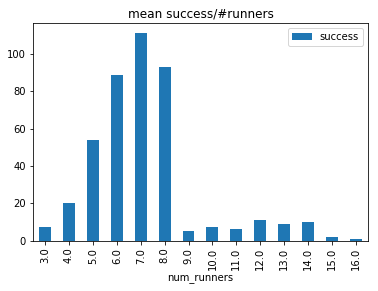

In [56]:
# profit per num runners
groups = df.groupby('num_runners').sum()
groups.plot(kind='bar', y='success', title='mean success/#runners')

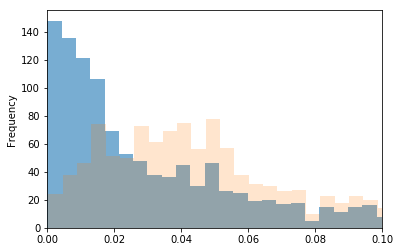

In [53]:
# max diff
df.win_diff.plot(kind='hist', xlim=(0, 0.1), bins=200, alpha=0.6)
df.max_diff.plot(kind='hist', xlim=(0, 0.1), bins=200, alpha=0.2)

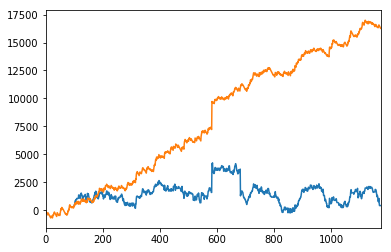

In [54]:
df.profit.rolling(100).sum().plot()
df.profit.cumsum().plot()

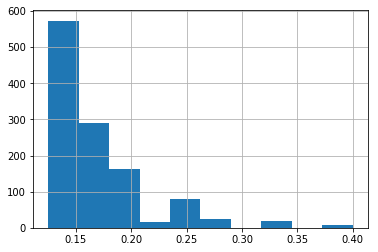

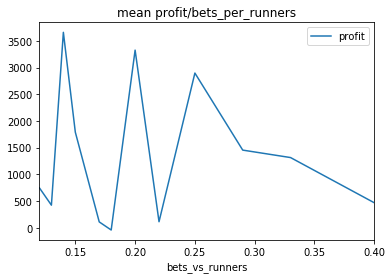

In [55]:
# bets/runners
df['bets_vs_runners'] = df.num_bets / df.num_runners
df['bets_vs_runners'].hist(bins=10)
groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 2))).sum()
groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')